In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 44100
blocksize = 88200
overlap = 22050

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50

In [7]:
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        fld=range(2,6), 
                        blocksize=blocksize, 
                        overlap=overlap)

Preprocess file not found, building new one
Epoch 1/1
2/2 [==============================] - 0s 65ms/step - loss: 1.2460
Epoch 1/1
2/2 [==============================] - 0s 37ms/step - loss: 1.3315
	Bytes: 4211344
	Processing Time: 42.17207741737366


In [11]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,l_target,h_target
count,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,...,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000
mean,48.430784,50.418929,35.734120,31.474226,28.507680,26.971181,25.125723,25.069451,23.399979,23.032275,...,-0.010097,0.009135,-0.008238,0.006505,-0.007245,0.004310,-0.004971,0.003052,0.623402,24.497135
std,25.369643,28.666028,16.331744,13.891217,12.231724,11.416638,10.456013,10.425420,9.544580,9.385765,...,0.030425,0.029254,0.027525,0.027105,0.025615,0.025173,0.024499,0.023142,0.484586,14.519294
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.156495,-0.139783,-0.155228,-0.126032,-0.139114,-0.121857,-0.126223,-0.122716,0.000000,0.000000
25%,29.474898,27.023068,23.575613,21.494624,20.154840,19.262486,18.013971,18.408166,17.044587,16.872658,...,-0.025173,-0.007681,-0.022001,-0.009076,-0.020681,-0.010344,-0.018532,-0.010127,0.000000,12.000000
50%,46.511030,47.030497,36.043425,31.848399,29.220590,27.193243,25.594728,25.610608,23.754334,23.560967,...,-0.005667,0.004993,-0.004546,0.003025,-0.004265,0.001313,-0.002949,0.000857,1.000000,24.000000
75%,64.705746,71.098213,46.809207,40.794668,36.352064,34.705359,32.375933,32.125075,30.069079,29.619586,...,0.006257,0.024001,0.006862,0.019628,0.007518,0.017877,0.008707,0.015849,1.000000,37.000000
max,162.944580,148.114151,93.262978,89.367409,91.938995,68.260246,67.058037,67.830833,60.431767,62.603237,...,0.140499,0.153488,0.142751,0.147354,0.146182,0.147818,0.146564,0.131608,1.000000,49.000000


In [21]:
from sklearn.model_selection import train_test_split
train, test, = train_test_split(
                        df, test_size=0.20)

In [22]:
train_X = train.drop(['l_target', 'h_target'], axis=1)
train_y = train['l_target']
test_X = test.drop(['l_target', 'h_target'], axis=1)
test_y = test['l_target']

# Shallow Net
Separate into classes

In [25]:
from keras.layers import Dense, Dropout
from keras.models import Sequential

def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Dense(114, activation='relu', input_shape=(114,)))
    model.add(Dropout(0.2))
    model.add(Dense(114, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

In [27]:
anim = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, 
                       epochs=200, 
                       batch_size=200, 
                       validation_split=0.15)
history = anim.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 114)               13110     
_________________________________________________________________
dropout_19 (Dropout)         (None, 114)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 114)               13110     
_________________________________________________________________
dropout_20 (Dropout)         (None, 114)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               14720     
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 32)                4128      
__________

3085/3085 [==============================] - 0s 34us/step - loss: 6.0152 - acc: 0.6227 - val_loss: 5.9674 - val_acc: 0.6257
Epoch 49/200
3085/3085 [==============================] - 0s 33us/step - loss: 6.0152 - acc: 0.6227 - val_loss: 5.9674 - val_acc: 0.6257
Epoch 50/200
3085/3085 [==============================] - 0s 34us/step - loss: 6.0152 - acc: 0.6227 - val_loss: 5.9674 - val_acc: 0.6257
Epoch 51/200
3085/3085 [==============================] - 0s 34us/step - loss: 6.0152 - acc: 0.6227 - val_loss: 5.9674 - val_acc: 0.6257
Epoch 52/200
3085/3085 [==============================] - 0s 34us/step - loss: 6.0152 - acc: 0.6227 - val_loss: 5.9674 - val_acc: 0.6257
Epoch 53/200
3085/3085 [==============================] - 0s 33us/step - loss: 6.0152 - acc: 0.6227 - val_loss: 5.9674 - val_acc: 0.6257
Epoch 54/200
3085/3085 [==============================] - 0s 33us/step - loss: 6.0152 - acc: 0.6227 - val_loss: 5.9674 - val_acc: 0.6257
Epoch 55/200
3085/3085 [==============================

Epoch 108/200
3085/3085 [==============================] - 0s 34us/step - loss: 6.0152 - acc: 0.6227 - val_loss: 5.9674 - val_acc: 0.6257
Epoch 109/200
3085/3085 [==============================] - 0s 34us/step - loss: 6.0152 - acc: 0.6227 - val_loss: 5.9674 - val_acc: 0.6257
Epoch 110/200
3085/3085 [==============================] - 0s 34us/step - loss: 6.0152 - acc: 0.6227 - val_loss: 5.9674 - val_acc: 0.6257
Epoch 111/200
3085/3085 [==============================] - 0s 34us/step - loss: 6.0152 - acc: 0.6227 - val_loss: 5.9674 - val_acc: 0.6257
Epoch 112/200
3085/3085 [==============================] - 0s 33us/step - loss: 6.0152 - acc: 0.6227 - val_loss: 5.9674 - val_acc: 0.6257
Epoch 113/200
3085/3085 [==============================] - 0s 32us/step - loss: 6.0152 - acc: 0.6227 - val_loss: 5.9674 - val_acc: 0.6257
Epoch 114/200
3085/3085 [==============================] - 0s 34us/step - loss: 6.0152 - acc: 0.6227 - val_loss: 5.9674 - val_acc: 0.6257
Epoch 115/200
3085/3085 [=========

3085/3085 [==============================] - 0s 33us/step - loss: 6.0152 - acc: 0.6227 - val_loss: 5.9674 - val_acc: 0.6257
Epoch 168/200
3085/3085 [==============================] - 0s 33us/step - loss: 6.0152 - acc: 0.6227 - val_loss: 5.9674 - val_acc: 0.6257
Epoch 169/200
3085/3085 [==============================] - 0s 33us/step - loss: 6.0152 - acc: 0.6227 - val_loss: 5.9674 - val_acc: 0.6257
Epoch 170/200
3085/3085 [==============================] - 0s 33us/step - loss: 6.0152 - acc: 0.6227 - val_loss: 5.9674 - val_acc: 0.6257
Epoch 171/200
3085/3085 [==============================] - 0s 35us/step - loss: 6.0152 - acc: 0.6227 - val_loss: 5.9674 - val_acc: 0.6257
Epoch 172/200
3085/3085 [==============================] - 0s 35us/step - loss: 6.0152 - acc: 0.6227 - val_loss: 5.9674 - val_acc: 0.6257
Epoch 173/200
3085/3085 [==============================] - 0s 35us/step - loss: 6.0152 - acc: 0.6227 - val_loss: 5.9674 - val_acc: 0.6257
Epoch 174/200
3085/3085 [=======================

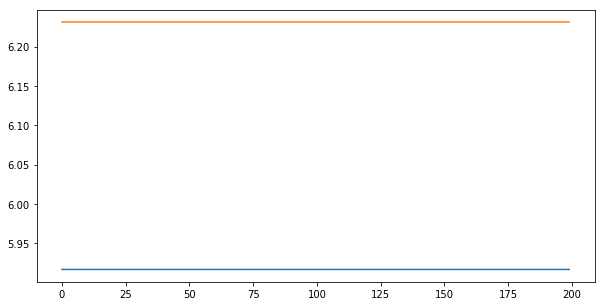

In [16]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

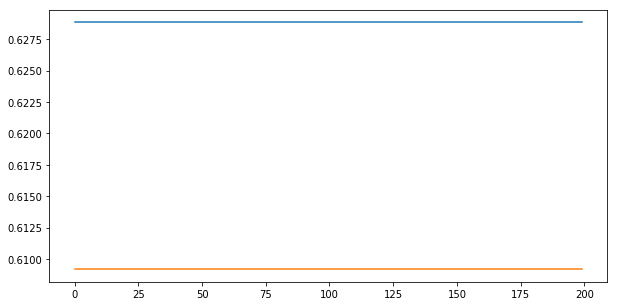

In [17]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.6134361233480177
Confusion matrix, without normalization
[[  0 351]
 [  0 557]]


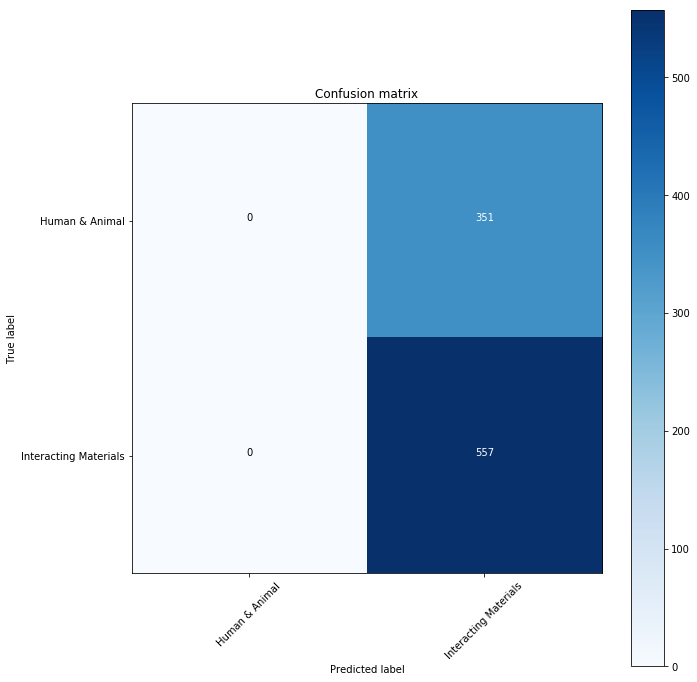

In [18]:
pred = anim.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# All Data

In [19]:
all_df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        fld=1, 
                        blocksize=blocksize, 
                        overlap=overlap)

In [20]:
X = all_df.drop(['l_target', 'h_target'], axis=1)
y = all_df['l_target']

0.6252220248667851
Confusion matrix, without normalization
[[  0 422]
 [  0 704]]


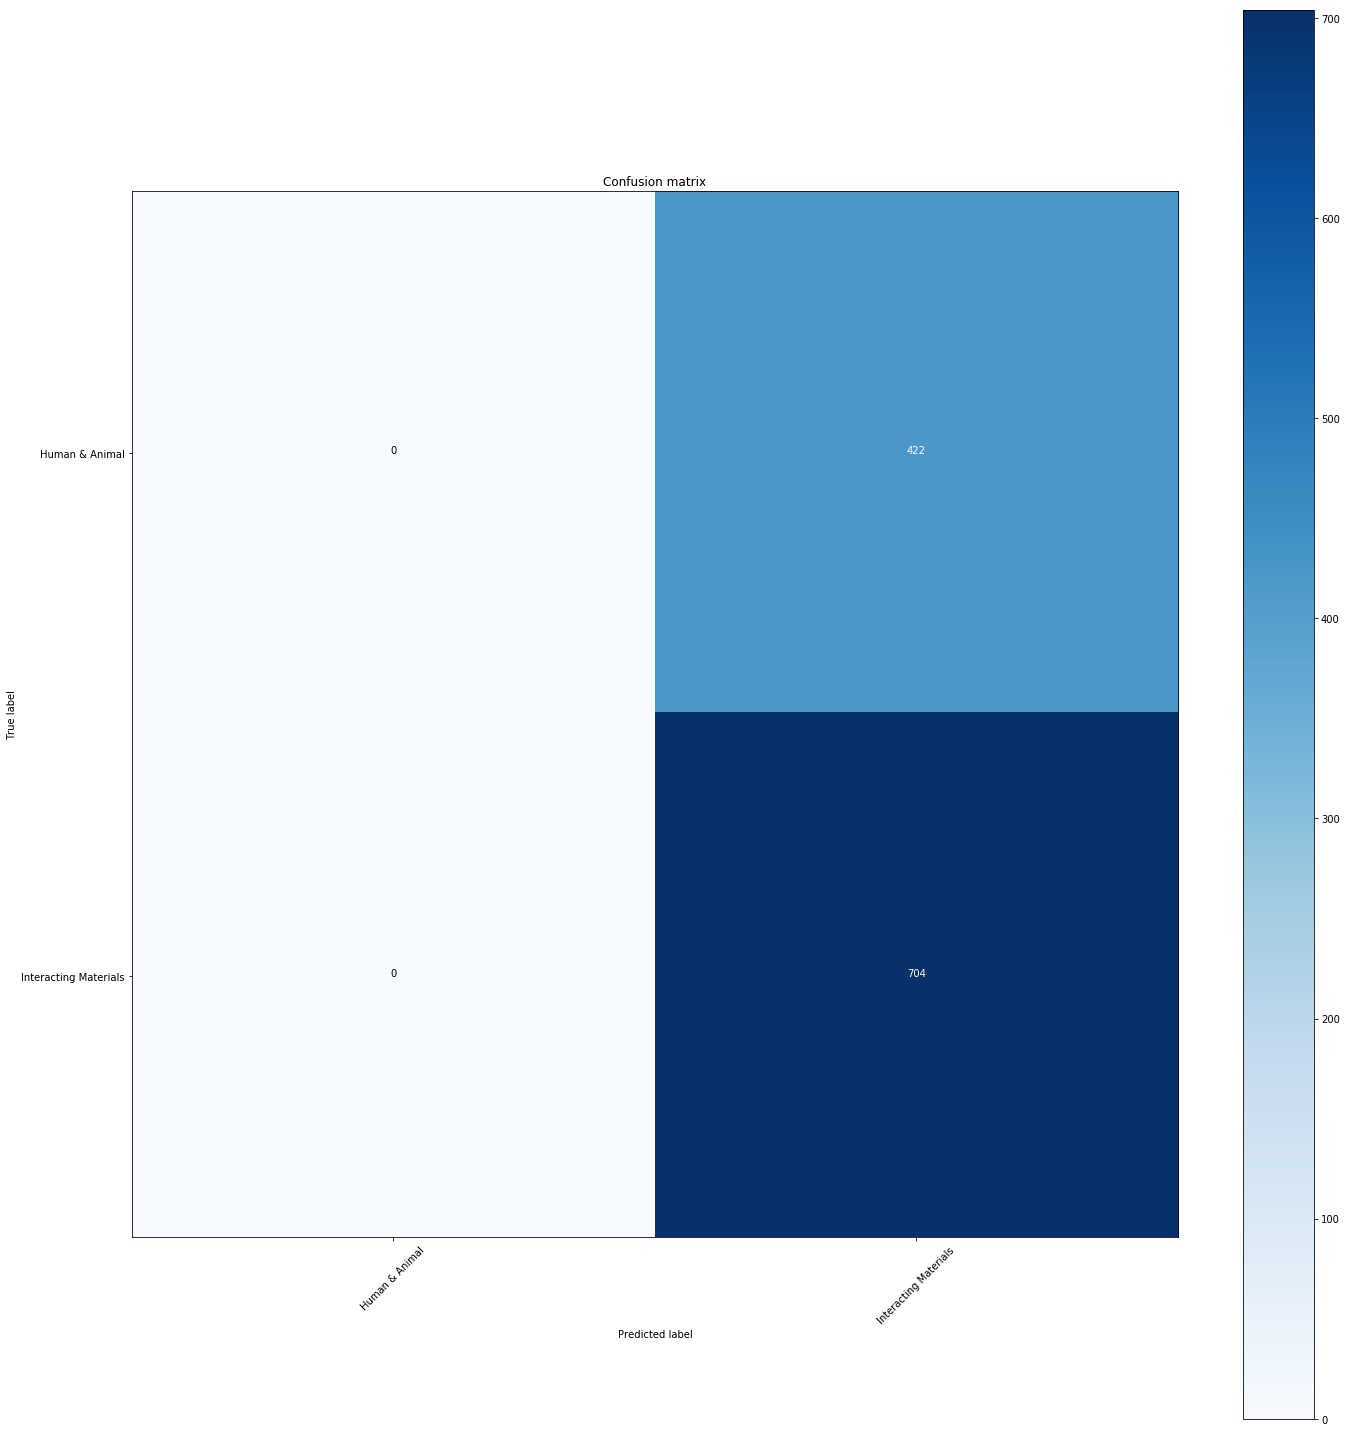

In [21]:
pred = anim.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, h_classes)
plt.show()